# Chapter #5 Making own theme portfolio
### 2020.05.29

In [36]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from urllib.parse import quote
import requests
import datetime as dt
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
import re

## Scraping stock index data

In [128]:
def date_format(d):
    d = str(d).replace('-', '.')
    yyyy = int(d.split('.')[0])
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])
    
    this_date = dt.date(yyyy, mm, dd)
    return this_date

- Korean stock index data (from NAVER)

In [129]:
def read_json(d, symbol, page=1):
    url = 'https://finance.naver.com/world/worldDayListJson.nhn?symbol=' + symbol + '&fdtc=0&page=' + str(page)
    raw = urlopen(url)
    data = json.load(raw)
    
    for n in range(len(data)):
        date = pd.to_datetime(data[n]['xymd']).date()
        price = float(data[n]['clos'])
        d[date] = price
        
    if len(data) == 10:
        page += 1
        read_json(d, symbol, page)
        
    return d

In [130]:
def date_format(d=''):
    if d != '':
        this_date = pd.to_datetime(d).date()
    else:
        this_date = pd.Timestamp.today().date()
    return (this_date)

In [152]:
def stock_info(stock_cd):
    url_float = 'http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=' + stock_cd
    source = urlopen(url_float).read()
    soup = bs(source, 'lxml')
    print(stock_cd)
    
    tmp = soup.find(id='cTB11').find_all('tr')[6].td.text
    tmp = tmp.replace('\r', '').replace('\n','').replace('\t','')
    tmp = re.split('/', tmp)
                   
    outstanding = tmp[0].replace(',','').replace('주','').replace(' ','')
    outstanding = int(outstanding)
                   
    floating = tmp[1].replace(' ','').replace('%','')
    floating = float(floating)
                   
    name = soup.find(id='pArea').find('div').find('div').find('tr').find('td').find('span').text
    
    stock_outstanding[stock_cd] = outstanding
    stock_floating[stock_cd] = floating
    stock_name[stock_cd] = name

In [153]:
stock_outstanding = dict()
stock_floating = dict()
stock_name = dict()
for stock_cd in target_theme.keys():
    stock_info(stock_cd)

003010
000910
081150
009520
015890


In [154]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
    
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_index).read()
    source = bs(source, 'lxml')
    
    dates = source.find_all('td', class_='date')
    prices = source.find_all('td', class_='number_1')
    
    for n in range(len(dates)):
        if dates[n].text.split('.')[0].isdigit():
            
            # Handling date
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                
                # Handling closing price
                this_close = prices[n*4].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
                
                historical_prices[this_date] = this_close

            elif this_date < start_date:
                return historical_prices
            
    
    # Navigating page
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page)
        
    if page_n < last_page:
        page_n += 1
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)
        
    return historical_prices

In [155]:
def historical_stock_naver(stock_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    if start_date:
        start_date = date_format(start_date)
    else:
        start_date = dt.date.today()
    if end_date:
        end_date = date_format(end_date)
    else:
        end_date = dt.date.today()
    
    naver_stock = 'http://finance.naver.com/item/sise_day.nhn?code=' + stock_cd + '&page=' + str(page_n)
    
    source = urlopen(naver_stock).read()
    #source = requests.get(naver_stock)
    source = bs(source, 'lxml')
    
    dates = source.find_all('span', class_='tah p10 gray03')
    prices = source.find_all('td', class_='num')
    
    for n in range(len(dates)):
        
        if len(dates) > 0:
            
            # Handling date
            this_date = dates[n].text
            this_date = date_format(this_date)
            
            if this_date <= end_date and this_date >= start_date:
                
                # Handling closing price
                this_close = prices[n*6].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
                
                historical_prices[this_date] = this_close

            elif this_date < start_date:
                return historical_prices
            
    
    # Navigating page
    if last_page == 0:
        last_page = source.find('td', class_='pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = last_page.split('=')[1]
        last_page = int(last_page)
        
    if page_n < last_page:
        page_n += 1
        historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)
        
    return historical_prices

In [156]:
kospi = pd.read_csv("kospi.csv", encoding='cp949')
kosdaq = pd.read_csv("kosdaq.csv", encoding='cp949')

# Input

In [157]:
target_company = ['혜인', '유니온', '티플랙스', '포스코엠텍', '태경산업']

In [158]:
target_theme = {}
for target in target_company:
    try:
        code = kosdaq[kosdaq['기업명']==target].iloc[0]['종목코드']
        code = str(code).zfill(6)
    except:
        code = kospi[kospi['기업명']==target].iloc[0]['종목코드']
        code = str(code).zfill(6)
    print(code, target)
    target_theme[code] = target

003010 혜인
000910 유니온
081150 티플랙스
009520 포스코엠텍
015890 태경산업


In [183]:
start_date = '2020-5-1'
end_date = '2020-6-1'

In [184]:
theme_historical_prices = dict()

for stock_cd in target_theme.keys():
    historical_prices = dict()
    historical_stock_naver(stock_cd, start_date, end_date)
    
    theme_historical_prices[stock_cd] = historical_prices
    
theme_historical_price = pd.DataFrame(theme_historical_prices)
theme_historical_price.sort_index(axis=1, inplace=True)

theme_historical_price = theme_historical_price.fillna(method='ffill')
if theme_historical_price.isnull().values.any():
    theme_historical_price = theme_historical_price.fillna(method='bfill')
theme_historical_price.head()

,000910,003010,009520,015890,081150
2020-06-01,6250.0,5810.0,5330.0,4970.0,3605.0
2020-05-29,6420.0,6200.0,5770.0,4920.0,3980.0
2020-05-28,6550.0,6140.0,5390.0,4935.0,3940.0
2020-05-27,7060.0,6260.0,5510.0,5030.0,3755.0
2020-05-26,6910.0,5960.0,4480.0,5030.0,2890.0


In [185]:
tmp = {'Outstanding' : stock_outstanding,\
       'Floating' : stock_floating,\
       'Price' : theme_historical_price.iloc[0],\
       'Name' : stock_name}
theme_info = pd.DataFrame(tmp)

In [186]:
theme_info['f Market Cap'] = theme_info['Outstanding'] * theme_info['Floating'] * theme_info['Price'] * 0.01
theme_info['Market Cap'] = theme_info['Outstanding'] * theme_info['Price'] * 0.01
theme_info.head(2)

,Outstanding,Floating,Price,Name,f Market Cap,Market Cap
000910,15611619,59.90,6250.0,유니온,5.844600e+10,975726187.5
003010,12712747,59.27,5810.0,혜인,4.377745e+10,738610600.7


In [187]:
theme_historical_mc = theme_historical_price * theme_info['Outstanding'] * theme_info['Floating'] * 0.01
theme_historical_mc.head(2)

,000910,003010,009520,015890,081150
2020-06-01,5.844600e+10,4.377745e+10,1.092687e+11,5.098868e+10,6.335851e+10
2020-05-29,6.003573e+10,4.671604e+10,1.182891e+11,5.047571e+10,6.994920e+10


In [188]:
theme = pd.DataFrame()
theme['Theme Market Cap'] = theme_historical_mc.sum(axis=1)
theme.sort_index(inplace=True)
theme['index'] = theme['Theme Market Cap'] / theme['Theme Market Cap'][0] * 100

In [189]:
historical_prices = dict()
kospi200 = historical_index_naver('KPI200', start_date, end_date)
k200 = pd.DataFrame({'K200':kospi200})

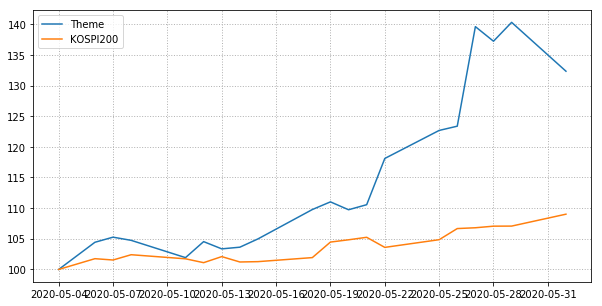

In [190]:
plt.figure(figsize=(10,5))
plt.plot(theme['index'] / theme['index'][0] * 100, label='Theme')
plt.plot(k200['K200'] / k200['K200'][0] * 100, label='KOSPI200')
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

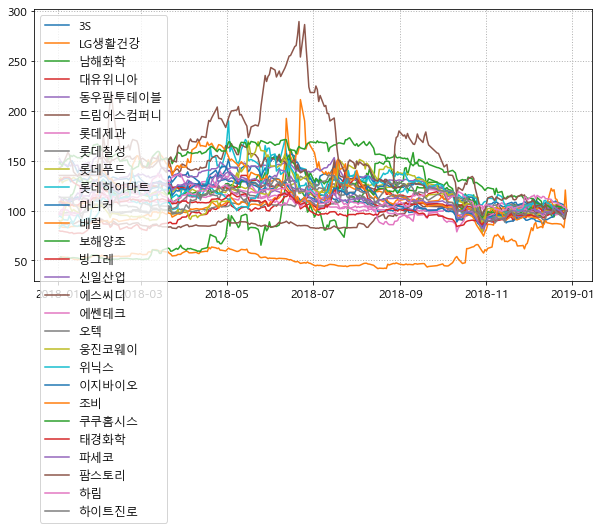

In [22]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
for i in range(len(target_theme)):
    v = theme_historical_mc.iloc[:, i]
    plt.plot(v/v[0]*100, label=list(target_theme.values())[i])

plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

## Making a new target after COVID-19

In [23]:
drop_list_2020 = ['3S', '남해화학', '드림어스컴퍼니', '배럴', '보해양조', '조비']
drop_num_2020 = []
for num, name in target.items():
    if name in drop_list_2020: drop_num_2020.append(num)

target_theme_2020 = target_theme.copy()
for i in drop_num_2020:
    target_theme_2020.pop(i)
    
target_theme_2020

{'051900': 'LG생활건강',
 '071460': '대유위니아',
 '088910': '동우팜투테이블',
 '280360': '롯데제과',
 '005300': '롯데칠성',
 '002270': '롯데푸드',
 '071840': '롯데하이마트',
 '027740': '마니커',
 '005180': '빙그레',
 '002700': '신일산업',
 '042110': '에스씨디',
 '043340': '에쎈테크',
 '067170': '오텍',
 '021240': '웅진코웨이',
 '044340': '위닉스',
 '035810': '이지바이오',
 '284740': '쿠쿠홈시스',
 '006890': '태경화학',
 '037070': '파세코',
 '027710': '팜스토리',
 '136480': '하림',
 '000080': '하이트진로'}

In [24]:
start_date = '2020-1-1'
end_date = '2020-06-05'

In [25]:
stock_outstanding = dict()
stock_floating = dict()
stock_name = dict()
for stock_cd in target_theme_2020.keys():
    stock_info(stock_cd)

In [26]:
theme_historical_prices = dict()

for stock_cd in target_theme_2020.keys():
    historical_prices = dict()
    historical_stock_naver(stock_cd, start_date, end_date)
    
    theme_historical_prices[stock_cd] = historical_prices
    
theme_historical_price = pd.DataFrame(theme_historical_prices)
theme_historical_price.sort_index(axis=1, inplace=True)

theme_historical_price = theme_historical_price.fillna(method='ffill')
if theme_historical_price.isnull().values.any():
    theme_historical_price = theme_historical_price.fillna(method='bfill')
theme_historical_price.head()

,000080,002270,002700,005180,005300,006890,021240,027710,027740,035810,...,043340,044340,051900,067170,071460,071840,088910,136480,280360,284740
2020-06-05,37850.0,377000.0,2355.0,66300.0,110000.0,6440.0,73000.0,1325.0,970.0,5520.0,...,1455.0,22850.0,1401000.0,13000.0,3205.0,29550.0,3860.0,3055.0,124500.0,39800.0
2020-06-04,38000.0,374500.0,2370.0,66300.0,109000.0,6480.0,74900.0,1295.0,966.0,4260.0,...,1460.0,23000.0,1403000.0,12850.0,3205.0,29000.0,3855.0,3040.0,124500.0,40050.0
2020-06-03,38050.0,377500.0,2295.0,65300.0,108000.0,6560.0,71500.0,1270.0,978.0,4260.0,...,1480.0,22950.0,1387000.0,13000.0,3250.0,28700.0,3875.0,3070.0,125500.0,39750.0
2020-06-02,38800.0,377500.0,2270.0,65100.0,107500.0,6310.0,69500.0,1345.0,994.0,4260.0,...,1420.0,21600.0,1370000.0,12900.0,3235.0,28500.0,3865.0,3125.0,125000.0,40100.0
2020-06-01,38750.0,377000.0,2300.0,65200.0,105500.0,6280.0,68500.0,1305.0,958.0,4260.0,...,1390.0,21300.0,1363000.0,13250.0,3195.0,28300.0,3870.0,3105.0,125000.0,40400.0


In [27]:
tmp = {'Outstanding' : stock_outstanding,\
       'Floating' : stock_floating,\
       'Price' : theme_historical_price.iloc[0],\
       'Name' : stock_name}
theme_info = pd.DataFrame(tmp)

In [28]:
theme_info['f Market Cap'] = theme_info['Outstanding'] * theme_info['Floating'] * theme_info['Price'] * 0.01
theme_info['Market Cap'] = theme_info['Outstanding'] * theme_info['Price'] * 0.01
theme_info.head(2)

,Outstanding,Floating,Price,Name,f Market Cap,Market Cap
000080,70133611,43.59,37850.0,하이트진로,1.157121e+12,2.654557e+10
002270,1131870,32.14,377000.0,롯데푸드,1.371462e+11,4.267150e+09


In [29]:
theme_historical_mc = theme_historical_price * theme_info['Outstanding'] * theme_info['Floating'] * 0.01
theme_historical_mc.head(2)

,000080,002270,002700,005180,005300,006890,021240,027710,027740,035810,...,043340,044340,051900,067170,071460,071840,088910,136480,280360,284740
2020-06-05,1.157121e+12,1.371462e+11,1.404291e+11,3.191229e+11,3.671876e+11,2.839499e+10,3.941401e+12,4.226561e+10,1.124143e+11,2.074091e+11,...,3.188894e+10,1.776982e+11,1.309146e+13,1.316198e+11,4.736657e+10,2.685093e+11,4.656485e+10,1.331952e+11,1.664070e+11,2.182506e+11
2020-06-04,1.161707e+12,1.362367e+11,1.413235e+11,3.191229e+11,3.638495e+11,2.857136e+10,4.043986e+12,4.130865e+10,1.119507e+11,1.600657e+11,...,3.199853e+10,1.788647e+11,1.311015e+13,1.301011e+11,4.736657e+10,2.635116e+11,4.650454e+10,1.325412e+11,1.664070e+11,2.196215e+11


In [30]:
theme = pd.DataFrame()
theme['Theme Market Cap'] = theme_historical_mc.sum(axis=1)
theme.sort_index(inplace=True)
theme['index'] = theme['Theme Market Cap'] / theme['Theme Market Cap'][0] * 100

In [31]:
historical_prices = dict()
kospi200 = historical_index_naver('KPI200', start_date, end_date)
k200 = pd.DataFrame({'K200':kospi200})

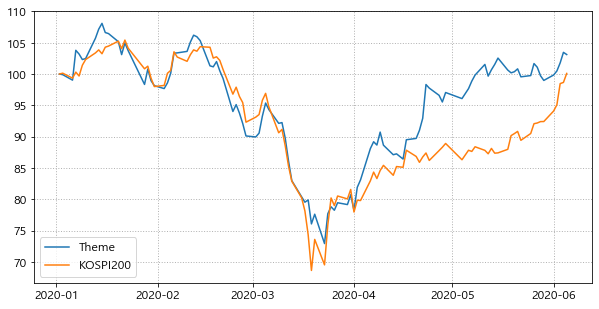

In [32]:
plt.figure(figsize=(10,5))
plt.plot(theme['index'] / theme['index'][0] * 100, label='Theme')
plt.plot(k200['K200'] / k200['K200'][0] * 100, label='KOSPI200')
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

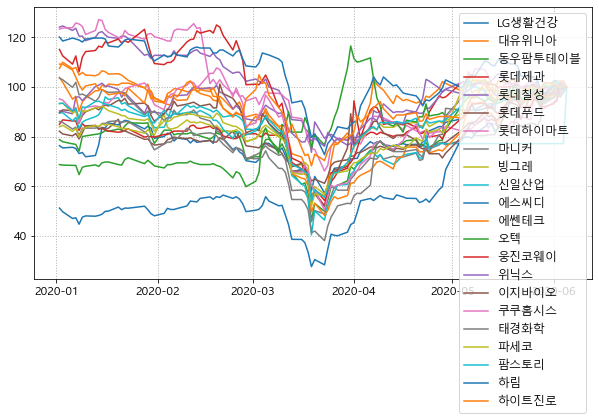

In [33]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
for i in range(len(target_theme_2020)):
    v = theme_historical_mc.iloc[:, i]
    plt.plot(v/v[0]*100, label=list(target_theme_2020.values())[i])

plt.legend(loc='upper right')
plt.grid(True, color='0.7', linestyle=':', linewidth=1)

In [ ]:
final_porfolio = {'한익스프레스', 
                  '제주항공', 
                  '하이트진로',
                  'S-Oil'}